In [1]:
import csv
import os
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import quad

from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/HD Actuator Specification/Haptic Reactor')

#
# Threshold of perception values
# adapted from Morioka, Griffin, 'Magnitude-dependence of equivalent comfort contours for force-and-aft, lateral and vertical hand-transmitted vibration', Journal of Sound and Vibration, 295 (2006) 633-648.
#
frequencyIdx_ToP    = [8,      10,  12.5,    16,   20,    25,   31.5,    40,    50,    63,    80,   100,   125,   160,   200,   250,   315 ]
mag_acc_ms2_rms_ToP = [0.095, 0.1, 0.095, 0.108, 0.15,  0.16,  0.109, 0.065, 0.072, 0.049, 0.028, 0.023, 0.022, 0.021, 0.029, 0.032, 0.061]

accelToP_RMS = interp1d( frequencyIdx_ToP, mag_acc_ms2_rms_ToP, fill_value ='extrapolate')

#
# Frequency discrimination threshold
# 
frequencyIdx_JND = [50,70,90,110,130,150,170,190,210,230,250]
frequency_JND = [16,25.4,32.1,38.9,43.2,40.2,37.2,34.1,31.1,28.0,25.0]
freqJND = interp1d( frequencyIdx_JND, frequency_JND, fill_value ='extrapolate' )

Mounted at /content/drive


In [70]:
#testData = np.genfromtxt('VCM_3Cycles.csv', delimiter=',') # singleFrqDataSize=5200, accIdx=1, freqNumSamples=90
#testData = np.genfromtxt('Force Reactor_4Vp-p_10cycles.csv', delimiter=',')# singleFrqDataSize=5000, accIdx=3,4, freqNumSamples=91
#testData = np.genfromtxt('Force Reactor_4Vp-p_5cycles.csv', delimiter=',')# singleFrqDataSize=5000, accIdx=3,4, freqNumSamples=91
testData = np.genfromtxt('Force Reactor 3Vpp 10cycles 20g mass.csv', delimiter=',')


The driving signal has the following characteristics

* Magnitude: 3 Vpp
* Frequency range: 50 - 500 Hz, increments of 5Hz
* Number of samples: 91
* Time with zero magnitude between pulses: 0.5 sec
* Sampling rate: 10kHz


In [74]:
singleFrqDataSize=5000
accIdx=3
freqNumSamples=91

startFreq = 50
endFreq = 500

print( testData.size )

freqData = testData[0:testData.size,accIdx].reshape(-1,singleFrqDataSize)
timeData = testData[0:singleFrqDataSize,0]
inputFreq = np.linspace(startFreq,endFreq,freqNumSamples)

2525000


(101, 5000)


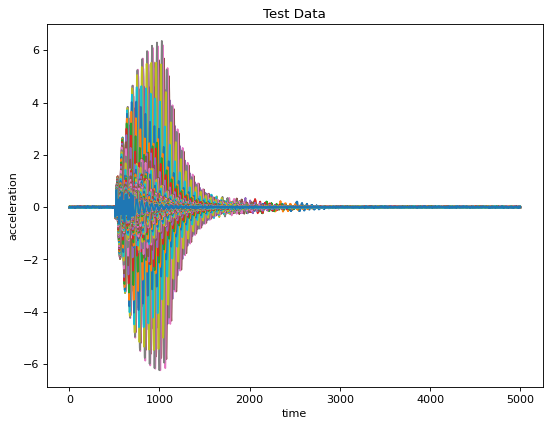

In [75]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k') 
plt.xlabel('time') 
plt.ylabel('acceleration')
plt.title('Test Data')

# superimpose the time domain acceleration respose to input at different frequencies
for x in range(freqNumSamples):
    plt.plot(freqData[x,:]) 
print(freqData.shape) 

HD Fundamental Test

---



1. Perform a frequency sweep using 3 or more cycles at each frequency and extract the maximum peak-to-peak acceleration from the system response.
2. Select three frequencies that are perceptually distinct using this perception estimates in the Resources section of this document.
3. Verify that the output signal’s dominant frequency component is at the selected drive frequency in each case
4. For each frequency, measure the acceleration headroom above threshold of perception (use table in appendix)
5. If the amplitude range at all selected frequencies is .5G or higher, the component is HD




In [77]:
#
# Given timeseries sampled at time_step s, compute the frequency of the peak of the power spectrum
#
def peakFrequency( testFrequency, data, time_step, doPlot=True ):
  rate = 1/time_step

  # compute real FFT
  p_raw = np.abs(np.fft.rfft(data))
  p = 20*np.log10(p_raw)

  # array of frequencies
  f = np.linspace(0, rate/2, len(p))

  if doPlot:
    plt.plot( f, p_raw )

  # find index of largest elements
  idx = np.argsort( -p )

  # compute pk-pk acceleration
  accIdx = np.argsort( data )
  pkpk = data[accIdx[accIdx.size-1]]-data[accIdx[0]]

  # find pkpk perceptual threshold at this frequency
  # Convert RMS thresholds to pk-pk to enable comparison PkPk = 2* sqrt(2) * RMS (assumes RMS values are based on sin waves)
  accelToP_PkPk = 2.0*np.sqrt(2.0)*accelToP_RMS( testFrequency )

  dynamicHeadroom = pkpk - accelToP_PkPk 

  # compute distortion
  power = interp1d( f, p_raw, fill_value ='extrapolate')

  # find the perceptual range for the test frequency
  freqLimit = freqJND( testFrequency )
  # integrate the output power in the perceptual range of the test frequency
  #
  sampleFreqs = np.arange( testFrequency-freqLimit, testFrequency+freqLimit, 1 )
  testPower = np.sum( power( sampleFreqs ) )

  # integrate from 0-500Hz
  #
  sampleFreqs = np.arange( 0, 500, 1 )
  totalPower = np.sum( power(sampleFreqs) )

  # calculate how much output energy is in the perceptual band of the drive signal as a fraction of total output energy (as a percentage)
  distortion = 100*(1.0 - testPower/totalPower)

  return [ f[idx[0]], pkpk, dynamicHeadroom, distortion] #rmsPk, rmsTime ]

In [9]:
def checkInputFrequencies( freq1, freq2 ):
  freqDiff = abs( freq1-freq2 )
  maxFreqJND = max( freqJND(freq1), freqJND(freq2))

  if( freqDiff < maxFreqJND ):
    print( '    Test frequencies ' + str(freq1) + 'Hz '+ str(freq2) + 'Hz are closer than ' + str( maxFreqJND ) + 'Hz' )
    return False
  else:
    return True


Quality Factor: 4.380952380952381


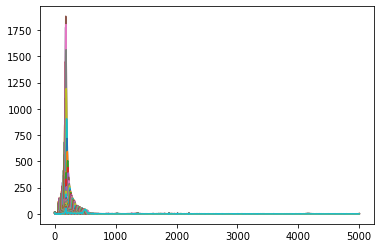

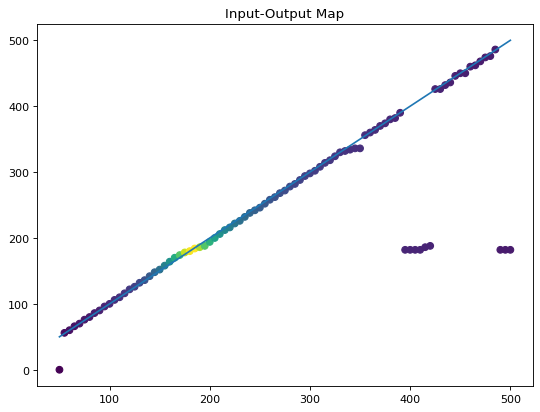

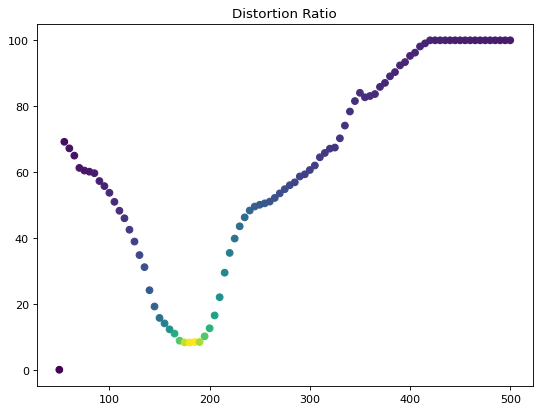

In [78]:
#
# For all available time series, compute the peak frequency and plot input-output map
#
# We'll use this information to guess some test frequency points
#
diagX = [50,500]
diagY = [50,500]

idx = range(1,freqNumSamples)
outFreq = np.zeros(freqNumSamples)
outMagnitude = np.zeros(freqNumSamples)
distortion = np.zeros(freqNumSamples)
pkOutput = 0.0
pkIdx = -1
for i in idx:
  freqOut = peakFrequency( inputFreq[i], freqData[i,:], time_step )
  outFreq[i] = freqOut[0]
  outMagnitude[i] = freqOut[2]
  distortion[i] = freqOut[3]
  if outMagnitude[i] > pkOutput:
    pkOutput = outMagnitude[i]
    pkIdx = i

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k' )
plt.title( 'Input-Output Map') 
plt.scatter( inputFreq, outFreq, c=outMagnitude )
plt.plot( diagX, diagY )

figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k') 
plt.title( 'Distortion Ratio') 
plt.scatter( inputFreq, distortion, c=outMagnitude )

#
# Estimate Q value
#
# Find peak frequency
halfMax = pkOutput/2
maxFreqs = outFreq[outMagnitude > halfMax ] 
print( 'Quality Factor: ' + str( outFreq[pkIdx]/(maxFreqs[maxFreqs.size-1] - maxFreqs[0] )) ) 

Test Frequencies: 100.0Hz 160.0Hz 200.0Hz 
Test frequencies are perceptually distinct. Proceeding with signal analysis.

Input Frequency: 100.00 (64.50,135.50) Peak Frequency: 100.00Hz Acceleration Peak: 1.46G Dynamic Headroom: 1.40G Distortion: 53.71%
Input Frequency: 160.00 (121.30,198.70) Peak Frequency: 164.00Hz Acceleration Peak: 6.47G Dynamic Headroom: 6.41G Distortion: 12.26%
Input Frequency: 200.00 (167.40,232.60) Peak Frequency: 194.00Hz Acceleration Peak: 8.08G Dynamic Headroom: 7.99G Distortion: 12.59%
============ Part PASSED ===========


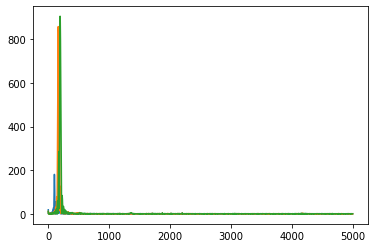

In [80]:
#
# Select 3 distinct frequency indicies
#
idx = [10,22,30]
testFreq = inputFreq[idx]

print( 'Test Frequencies: '+ str(testFreq[0]) + 'Hz '+ str(testFreq[1]) + 'Hz '+ str(testFreq[2]) + 'Hz ')
#
# Frequency discrimination check 
#
goodTestFrequencies = True

if( checkInputFrequencies( testFreq[0], testFreq[1]) == False):
  goodTestFrequencies = False
  
if( checkInputFrequencies( testFreq[1], testFreq[2]) == False):
  goodTestFrequencies = False
  
if( checkInputFrequencies( testFreq[0], testFreq[2]) == False):
  goodTestFrequencies = False

partPass = False
if( goodTestFrequencies ):
  
  print( 'Test frequencies are perceptually distinct. Proceeding with signal analysis.\n')
  # constant sampling
  time_step = (timeData[2]-timeData[1])

  # assume part passed
  partPass = True

  #
  # For each test frequency, test the input-output frequency performance and dynamic headroom
  #
  for i in idx:

    inFreq = inputFreq[i]

    [outFreq, pkpkAcc, dynamicHeadroom, distortion ] = peakFrequency( inFreq, freqData[i,:], time_step )
    
    print( 'Input Frequency: {:.2f}'.format(inFreq) + ' ({:.2F},'.format(inFreq-freqJND(inFreq)) + '{:.2f})'.format(inFreq+freqJND(inFreq)) + ' Peak Frequency: {:.2f}'.format(outFreq)+ 'Hz '+ 'Acceleration Peak: {:.2f}'.format(pkpkAcc) + 'G' + ' Dynamic Headroom: {:.2f}'.format(dynamicHeadroom) + 'G' + ' Distortion: {:.2f}'.format(distortion) + '%')

    #
    # Check if the peak output frequency is within the frequency threshold
    #
    fRange = freqJND( inputFreq[i] )
    if( abs( outFreq-inputFreq[i])> fRange ):
      print( '\n     FAIL frequency mapping requirement: {:.2f}'.format(outFreq) + ' -{:.2f} > '.format(inFreq) + '{:.2f}'.format(fRange))
      partPass = False
    

    # Check if the headroom is greater than 0.5G 
    # TODO: need to calculate RMS based on the non-zero signal period

    if( dynamicHeadroom < 0.5 ):
      print('\n     FAIL dynamic headroom requirement')
      partPass = False
else:
  print('============ Select New Test Frequencies ===========')

if( partPass == False ):
  print('============ Part FAILED ===========')
else:
  print('============ Part PASSED ===========')